In [ ]:
!pip install snntorch --quiet
!pip install scikit-learn --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.utils.data import DataLoader, Dataset

class EEGDataset(Dataset):

    def __init__(self, path):

        ####################
        ### Loading data ###
        ####################

        mat = loadmat(path, struct_as_record=True, squeeze_me=True, mat_dtype=False)

        #################################
        ### Setting up the properties ###
        #################################

        self.estimuli = {
                1 : "A",
                2 : "E",
                3 : "I",
                4 : "O",
                5 : "U",
                6 : "Arriba",
                7 : "Abajo",
                8 : "Adelante",
                9 : "Atrás",
                10 : "Derecha",
                11 : "Izquierda"
            }

        # Modalities
        self.modalities = {
            1 : "Imaginada",
            2 : "Falada"
        }

        # Artfacts
        self.artfacts = {
            -1 : "Indiferente",
            1 : "Com artefato",
            2 : "Sem artefato"
        }

        self.dataframe = pd.DataFrame(mat['EEG'])

        # Creates 6 channels of EEG data
        self.channels = 6
        self.channelsLength = 4096
        self._joinIntoArray(0, 4096, 'F3', self.dataframe)
        self._joinIntoArray(0, 4096, 'F4', self.dataframe)
        self._joinIntoArray(0, 4096, 'C3', self.dataframe)
        self._joinIntoArray(0, 4096, 'C4', self.dataframe)
        self._joinIntoArray(0, 4096, 'P3', self.dataframe)
        self._joinIntoArray(0, 4096, 'P4', self.dataframe)

        # Creates 3 more channels:
        # labels 'Estímulo'
        # artifacts 'Modalidade' and 'Artefatos'
        self._joinIntoValue(0, 1, 'Modalidade', self.dataframe)
        self._joinIntoValue(0, 1, 'Estímulo', self.dataframe)
        self._joinIntoValue(0, 1, 'Artefatos', self.dataframe)

        self.filteredData = self.dataframe[(self.dataframe['Modalidade'] == 1) & (self.dataframe['Artefatos'] == 1)]

        self.labels = self.filteredData['Estímulo'].values
        self.data = self.filteredData[['F3','F4','C3','C4','P3','P4']].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample_data =  torch.tensor(self.data[idx].tolist(),dtype=torch.float) # Convert numpy arrays to tensors
        sample_label = torch.tensor(self.labels[idx].tolist(),dtype=torch.float)  # Ensure labels are also tensors
        return sample_data, sample_label

    # Auxiliary methods
    def _joinIntoArray(self, start_col, end_col, newColumn, dataframe):
        cols_to_join = dataframe.iloc[:, start_col:end_col].columns
        dataframe[newColumn] = dataframe[cols_to_join].apply(lambda x: np.array(pd.to_numeric(x, errors='coerce')), axis=1)
        dataframe.drop(cols_to_join, axis=1, inplace=True)

    def _joinIntoValue(self, start_col, end_col, newColumn, dataframe):
        cols_to_join = dataframe.iloc[:, start_col:end_col].columns
        dataframe[newColumn] = dataframe[cols_to_join].apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
        dataframe.drop(cols_to_join, axis=1, inplace=True)

In [ ]:
import math
import torch
import torch.nn as nn
# from data import EEGDataset
from torch import nn, save, load
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt

# Define a simple neural network architecture with dynamic size calculation
class EEGNet(nn.Module):
    def __init__(self, input_channels, input_timepoints):
        super(EEGNet, self).__init__()

        ############################################################
        ######## Calculates the size of the feature vector #########
        ############################################################

        # Calculate the size of the features after the 1st conv and pool layers
        feature_size = self.get_tensor_size_after_conv(input_timepoints,5)
        feature_size = self.get_tensor_size_after_maxpool(feature_size,2)
        # Calculate the size of the features after the 2nd conv and pool layers
        feature_size = self.get_tensor_size_after_conv(feature_size,5)
        feature_size = self.get_tensor_size_after_maxpool(feature_size,2)
        # Calculate the size of the features after the flatten
        feature_size = feature_size * 32


        ################################
        ###### Creates the model #######
        ################################

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=5),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(feature_size, 128),
            nn.ReLU(),
            nn.Linear(128, 27)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def save_model(self, path):
        with open(path, 'wb') as f:
            save(self.state_dict(), f)

    def load_model(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(load(f))

    def get_tensor_size_after_conv(self, input_size, convolution_kernel_size):
        return 1 +(input_size - convolution_kernel_size)

    def get_tensor_size_after_maxpool(self, input_size, poll_kernel_size):
        return math.floor(input_size / poll_kernel_size)

cuda


<ipython-input-3-73aa7bf92d2c>:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  sample_data =  torch.tensor(self.data[idx].tolist(),dtype=torch.float) # Convert numpy arrays to tensors


Epoch 0, Train Accuracy: 0.00%, Train Loss: 57.5385
Epoch 5, Train Accuracy: 0.00%, Train Loss: 4.9972
Epoch 10, Train Accuracy: 0.00%, Train Loss: 3.4520
Epoch 15, Train Accuracy: 0.00%, Train Loss: 2.4943
Epoch 20, Train Accuracy: 0.00%, Train Loss: 2.8337
Epoch 25, Train Accuracy: 0.00%, Train Loss: 3.7545
Epoch 30, Train Accuracy: 0.00%, Train Loss: 2.9013
Epoch 35, Train Accuracy: 0.00%, Train Loss: 4.0582
Epoch 40, Train Accuracy: 0.00%, Train Loss: 2.4988
Epoch 45, Train Accuracy: 0.00%, Train Loss: 4.3585
Epoch 50, Train Accuracy: 0.00%, Train Loss: 2.7476
Epoch 55, Train Accuracy: 0.00%, Train Loss: 1.9714
Epoch 60, Train Accuracy: 0.00%, Train Loss: 3.3789
Epoch 65, Train Accuracy: 0.00%, Train Loss: 3.5918
Epoch 70, Train Accuracy: 0.00%, Train Loss: 4.3170
Epoch 75, Train Accuracy: 0.00%, Train Loss: 2.5019
Epoch 80, Train Accuracy: 0.00%, Train Loss: 4.7698
Epoch 85, Train Accuracy: 0.00%, Train Loss: 3.9690
Epoch 90, Train Accuracy: 0.00%, Train Loss: 4.0781
Epoch 95, Tra

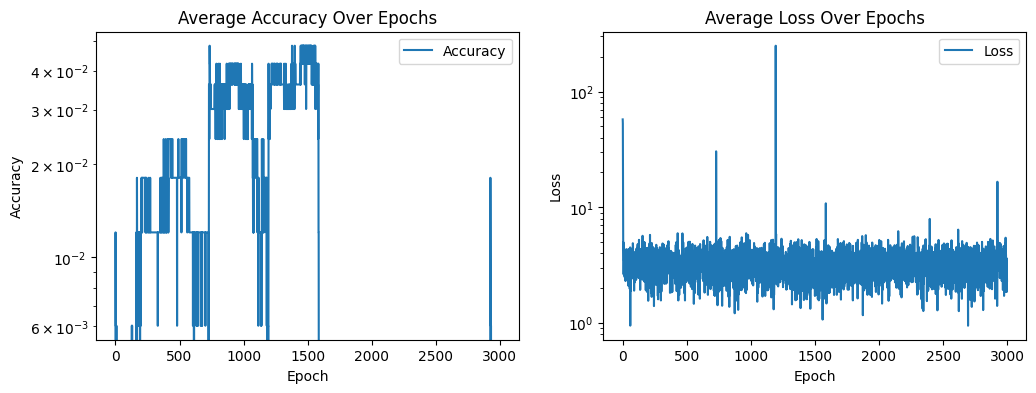

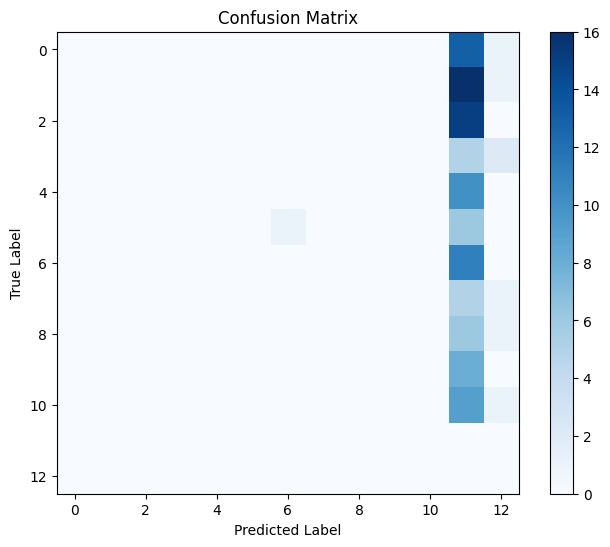

In [ ]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess data
data_path = '/content/drive/MyDrive/databases/S01_EEG.mat'
eegDataset = EEGDataset(data_path)

# Create model
model = EEGNet(eegDataset.channels, eegDataset.channelsLength)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.00001, 0.999))
loss_fn = nn.CrossEntropyLoss()

# Ensure that the network runs with floats
model.float()

# Get the indices for the entire dataset
dataset_size = len(eegDataset)
indices = list(range(dataset_size))

# Split the indices into training and validation sets
train_indices, test_indices = train_test_split(indices, test_size=0.4, random_state=42, shuffle=True)

# Create SubsetRandomSamplers for training and validation
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders using the SubsetRandomSamplers
train_loader = DataLoader(eegDataset, batch_size=10, sampler=train_sampler)
test_loader = DataLoader(eegDataset, batch_size=10, sampler=test_sampler)

# Loss and accuracy history
loss_hist = []  # record loss over iterations
accuracy_hist = []  # record accuracy over iterations

# Keeps the minimum loss
min_loss = 1000000

# Keeps the maximum loss
max_loss = 0

# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    # Initialize variables for computing accuracy and confusion matrix
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        # forward-pass
        model.train()
        spk_rec = model(data)

        loss_val = torch.zeros(1, dtype=torch.float, device=device)
        loss_val += loss_fn(spk_rec.sum(1).squeeze(), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Compute accuracy and update confusion matrix
        _, predicted = torch.max(spk_rec.data, 1)
        correct_preds += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

    # Calculate accuracy and loss
    accuracy = correct_preds / total_samples
    avg_loss = loss_val.item() / len(train_loader)

    # Update history
    accuracy_hist.append(accuracy)
    loss_hist.append(avg_loss)

    # Print and store results every 10 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Accuracy: {accuracy:.2%}, Train Loss: {avg_loss:.4f}")

# Save model
model.save_model("cnn.pth")

# Print max accuracy and min loss
print(f"Maximum Accuracy: {max(accuracy_hist):.2%}")
print(f"Minimum Loss: {min(loss_hist):.4f}")

# Plot average accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy_hist, label='Accuracy')
plt.yscale('log')
plt.title('Average Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_hist, label='Loss')
plt.yscale('log')
plt.title('Average Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("CnnAccuLoss.pdf")
plt.show()

# Evaluate on the test set
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for test_data, test_targets in test_loader:
        test_data, test_targets = test_data.to(device), test_targets.to(device)
        test_outputs = model(test_data)
        _, test_preds = torch.max(test_outputs.data, 1)
        all_test_preds.extend(test_preds.cpu().numpy())
        all_test_labels.extend(test_targets.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("CnnConfusinMatrix.pdf")
plt.show()


In [ ]:
import math
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from torch import nn, save, load
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from snntorch import utils
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import snntorch.functional as SF
import matplotlib.pyplot as plt

class SNNModel(nn.Module):
    def __init__(self, inputLength, insist = 4, neuronDecayRate = 0.9):
        super(SNNModel, self).__init__()

        self.insist = insist
        spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient

        ################################
        ###### Creates the model #######
        ################################

        self.model = nn.Sequential(
            nn.Linear(inputLength, 10000),
            snn.Leaky(beta=neuronDecayRate, spike_grad=spike_grad),
            nn.Linear(10000, 27),
            snn.Leaky(beta=neuronDecayRate, spike_grad=spike_grad),
            nn.AvgPool1d(27, stride=1)
        )

    def save_model(self, path):
        with open(path, 'wb') as f:
            save(self.state_dict(), f)

    def load_model(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(load(f))


    def forward(self, x):
        mem1 = self.model[1].init_leaky()
        mem2 = self.model[3].init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(self.insist):
            inputCurrent = self.model[0](x)
            spk1, mem1 = self.model[1](inputCurrent, mem1)

            inputSpikes = self.model[2](spk1)
            spk2, mem2 = self.model[3](inputSpikes, mem2)

            avg = self.model[4](spk2)

            spk2_rec.append(avg)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

cuda
Epoch 0, Train Accuracy: 93.98%, Train Loss: 2.7233
Epoch 5, Train Accuracy: 95.18%, Train Loss: 3.2575
Epoch 10, Train Accuracy: 86.75%, Train Loss: 2.1725
Epoch 15, Train Accuracy: 83.73%, Train Loss: 2.5963
Epoch 20, Train Accuracy: 83.13%, Train Loss: 2.5623
Epoch 25, Train Accuracy: 78.31%, Train Loss: 2.8522
Epoch 30, Train Accuracy: 80.72%, Train Loss: 1.9715
Epoch 35, Train Accuracy: 81.93%, Train Loss: 1.6260
Epoch 40, Train Accuracy: 90.36%, Train Loss: 3.7862
Epoch 45, Train Accuracy: 77.71%, Train Loss: 4.7089
Epoch 50, Train Accuracy: 60.24%, Train Loss: 1.6682
Epoch 55, Train Accuracy: 65.06%, Train Loss: 3.1615
Epoch 60, Train Accuracy: 53.01%, Train Loss: 3.9822
Epoch 65, Train Accuracy: 55.42%, Train Loss: 4.8857
Epoch 70, Train Accuracy: 45.18%, Train Loss: 3.3180
Epoch 75, Train Accuracy: 38.55%, Train Loss: 3.4795
Epoch 80, Train Accuracy: 48.19%, Train Loss: 3.4144
Epoch 85, Train Accuracy: 47.59%, Train Loss: 4.4314
Epoch 90, Train Accuracy: 62.05%, Train Los

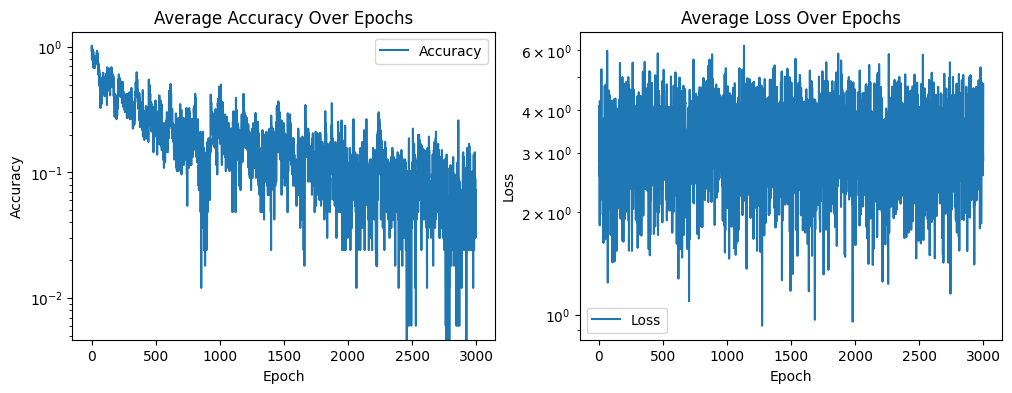

AttributeError: ignored

In [ ]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess data
data_path = '/content/drive/MyDrive/databases/S01_EEG.mat'
eegDataset = EEGDataset(data_path)

# Create model
insist = 4
neuronDecayRate = 0.9
model = SNNModel(
    inputLength=eegDataset.channelsLength,
    insist=insist,
    neuronDecayRate=neuronDecayRate
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.00001, 0.999))
loss_fn = nn.CrossEntropyLoss()

# Ensure that the network runs with floats
model.float()

# Get the indices for the entire dataset
dataset_size = len(eegDataset)
indices = list(range(dataset_size))

# Split the indices into training and validation sets
train_indices, test_indices = train_test_split(indices, test_size=0.4, random_state=42, shuffle=True)

# Create SubsetRandomSamplers for training and validation
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders using the SubsetRandomSamplers
train_loader = DataLoader(eegDataset, batch_size=10, sampler=train_sampler)
test_loader = DataLoader(eegDataset, batch_size=10, sampler=test_sampler)

# Loss and accuracy history
loss_hist = []  # record loss over iterations
accuracy_hist = []  # record accuracy over iterations

# Keeps the minimum loss
min_loss = 1000000

# Keeps the maximum loss
max_loss = 0

# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    # Initialize variables for computing accuracy and confusion matrix
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        # forward-pass
        model.train()
        spk_rec, _ = model(data)

        loss_val = torch.zeros(1, dtype=torch.float, device=device)
        loss_val += loss_fn(spk_rec.sum(2).sum(0).squeeze(), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Compute accuracy and update confusion matrix
        _, predicted = torch.max(spk_rec.sum(2),0)
        correct_preds += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

    # Calculate accuracy and loss
    accuracy = correct_preds / total_samples
    avg_loss = loss_val.item() / len(train_loader)

    # Update history
    accuracy_hist.append(accuracy)
    loss_hist.append(avg_loss)

    # Print and store results every 10 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Accuracy: {accuracy:.2%}, Train Loss: {avg_loss:.4f}")

# Save model
model.save_model("snn.pth")

# Print max accuracy and min loss
print(f"Maximum Accuracy: {max(accuracy_hist):.2%}")
print(f"Minimum Loss: {min(loss_hist):.4f}")

# Plot average accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy_hist, label='Accuracy')
plt.yscale('log')
plt.title('Average Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_hist, label='Loss')
plt.yscale('log')
plt.title('Average Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("SnnAccuLoss.pdf")
plt.show()

# Evaluate on the test set
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for test_data, test_targets in test_loader:
        test_data, test_targets = test_data.to(device), test_targets.to(device)
        test_outputs, _ = model(data)
        _, test_preds = torch.max(spk_rec.sum(2),0)
        all_test_preds.extend(test_preds.cpu().numpy())
        all_test_labels.extend(test_targets.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("SnnConfusinMatrix.pdf")
plt.show()
